In [1]:
from datasets import load_dataset

dataset = load_dataset('lambdalabs/pokemon-blip-captions')

In [2]:
dataset.get('train')

Dataset({
    features: ['image', 'text'],
    num_rows: 833
})

In [3]:
dataset.get('train')[110]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x1280>,
 'text': 'a cartoon monkey flying with a bone in its mouth'}

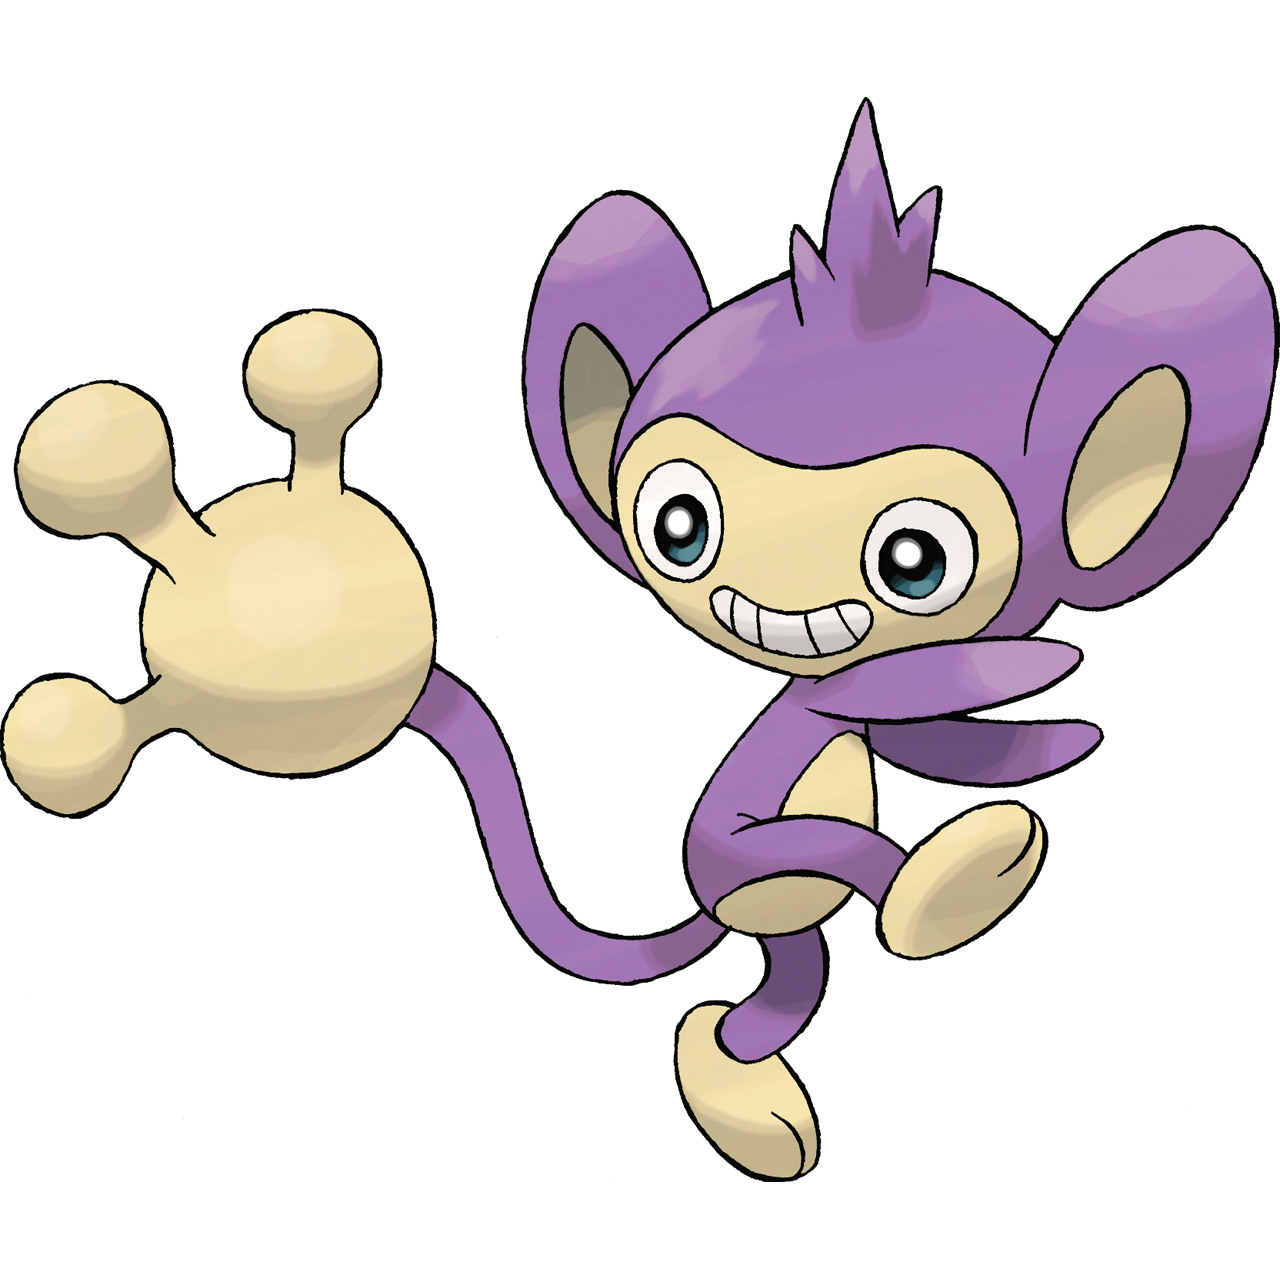

In [4]:
display(dataset.get('train')[110]['image'])

In [19]:
from transformers import GPT2TokenizerFast
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import os

In [20]:
BATCH_SIZE = 2
CONTEXT_SIZE = 128
PAD_TOKEN = '[PAD]'
IMAGE_SIZE = 512
DATASET_FILE = 'data/pokemon_train_dataset.hf/'

In [7]:

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
# tokenizer.add_special_tokens({"pad_token": PAD_TOKEN})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = 'right'

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),  # NOTE: This shuffles from (H, W, C) to (C, H, W)
        transforms.Normalize([0.5], [0.5]),  # TODO(2): Adjust normalization if needed. Can do linear transformation using transforms.lambda
    ]
)

def tokenize_and_resize(examples):
    tokenizer_output = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=CONTEXT_SIZE)
    return {
        'input_ids': tokenizer_output['input_ids'],
        'attention_mask': tokenizer_output['attention_mask'],
        'image': train_transforms(examples['image']),
    }

if os.path.exists('DATASET_FILE'):
    train_dataset = load_dataset('DATASET_FILE')
else:
    train_dataset = dataset['train'].map(tokenize_and_resize).with_format('torch')

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [18]:
train_dataset.save_to_disk('./data/pokemon_train_dataset.hf')

Saving the dataset (0/6 shards):   0%|          | 0/833 [00:00<?, ? examples/s]

In [8]:
print(tokenizer.pad_token_id)

50256


In [9]:
next(iter(train_loader))

{'image': tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]],
 
          [[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]],
 
 
         [[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [

In [10]:
next(iter(train_loader)).keys()

dict_keys(['image', 'text', 'input_ids', 'attention_mask'])

In [11]:
next(iter(train_loader))['image'].dtype

torch.float32

In [15]:
import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_EPOCHS = 2
LEARNING_RATE = 1e-5
NUM_DIFFUSION_TIMESTEPS = 100
LATENT_DIM = IMAGE_SIZE // 8

In [16]:
import torch.nn as nn
import torch.nn.functional as F

In [17]:
from diffusers import DDPMScheduler
from diffusers.optimization import get_constant_schedule
from model import LLourney

# TRAINING LOOP
model = LLourney()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = DDPMScheduler(num_train_timesteps=NUM_DIFFUSION_TIMESTEPS)
lr_schedule = get_constant_schedule(optimizer)

model.train()
step_i = 0
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for step, batch in enumerate(train_loader):
        step_i += 1
        image = batch["image"].to(DEVICE)
        text_id = batch["input_ids"].to(DEVICE)
        pad_mask = batch["attention_mask"].to(DEVICE)

        # Use VAE to encode image in latent space
        latent_image = model.encode_image(image)
        latent_image *= model.vae.config.scaling_factor
        assert latent_image.shape[-1] == LATENT_DIM

        # Sample gaussian with same shape as latent image
        Z = torch.randn_like(latent_image).to(DEVICE)

        # Sample timesteps, one for each item in the batch
        T = torch.randint(1, NUM_DIFFUSION_TIMESTEPS, (BATCH_SIZE,)).to(DEVICE)

        # Transform input images to noisy images now
        noisy_latent_image = scheduler.add_noise(latent_image, Z, T)

        # Use the model to predict the noise
        denoised_latent_noise = model(noisy_latent_image, text_id, T, text_pad_mask=pad_mask)

        # Calculate the loss
        loss_node = F.mse_loss(denoised_latent_noise, Z, reduction='mean')

        # Backpropagate
        loss_node.backward()
        optimizer.step()
        lr_schedule.step()
        optimizer.zero_grad()

        if step_i % 100 == 0:
            print(loss_node.item())

        

/Users/vibhorkumar/Documents/Programming/llourney/model.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_idx = torch.tensor(input_ids, dtype=torch.long, device=DEVICE)  # (B, T): [0, VOCAB_SIZE)


1.3789832592010498
1.4013302326202393
1.3092055320739746
1.305035948753357
1.2272953987121582
1.2078332901000977
1.2212108373641968
1.430564284324646
1.25038480758667
1.1568360328674316
1.1053733825683594
1.1370234489440918
1.1336734294891357
1.185054898262024
1.0604883432388306
1.132419466972351
1.0808780193328857
1.0785614252090454
1.0551930665969849
1.0596355199813843
1.069198727607727
1.0631272792816162
1.0989856719970703
1.0556141138076782
1.0289236307144165
1.0719716548919678
1.0417670011520386
1.0296580791473389
1.097066044807434
1.0397529602050781
1.051011562347412
1.0508620738983154
1.0295377969741821
1.0373879671096802
1.0298339128494263
1.0402439832687378
1.0253801345825195
1.034414291381836
1.0284335613250732
1.0481704473495483
1.031030297279358
1.0316317081451416
1.0544931888580322
1.0204291343688965
1.0184111595153809
1.023154854774475
1.0394833087921143
1.0247089862823486
1.0211347341537476
1.0489366054534912
1.0284624099731445
1.0176211595535278
1.0311305522918701
1.022

KeyboardInterrupt: 

In [29]:
NUM_INFERENCE_STEPS = 10

Latent noise shape: torch.Size([1, 4, 64, 64])
Batched t shape: torch.Size([1])
Input ids 666: torch.Size([1, 128])
Attention mask 666: torch.Size([1, 128])
patch_embs: torch.Size([1, 16, 768])
timestep_emb: torch.Size([1, 1, 768])
text_embs: torch.Size([1, 128, 768])
transformer_emb pre llama: torch.Size([1, 145, 768])
transformer_emb post llama: torch.Size([1, 145, 768])
projected_img_emb after projection: torch.Size([1, 16, 1024])
projected_img_emb after reshape: torch.Size([1, 4, 4, 16, 16, 4])
Batched t shape: torch.Size([1])
Input ids 666: torch.Size([1, 128])
Attention mask 666: torch.Size([1, 128])
patch_embs: torch.Size([1, 16, 768])
timestep_emb: torch.Size([1, 1, 768])
text_embs: torch.Size([1, 128, 768])
transformer_emb pre llama: torch.Size([1, 145, 768])


/Users/vibhorkumar/Documents/Programming/llourney/model.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_idx = torch.tensor(input_ids, dtype=torch.long, device=DEVICE)  # (B, T): [0, VOCAB_SIZE)


transformer_emb post llama: torch.Size([1, 145, 768])
projected_img_emb after projection: torch.Size([1, 16, 1024])
projected_img_emb after reshape: torch.Size([1, 4, 4, 16, 16, 4])
Batched t shape: torch.Size([1])
Input ids 666: torch.Size([1, 128])
Attention mask 666: torch.Size([1, 128])
patch_embs: torch.Size([1, 16, 768])
timestep_emb: torch.Size([1, 1, 768])
text_embs: torch.Size([1, 128, 768])
transformer_emb pre llama: torch.Size([1, 145, 768])
transformer_emb post llama: torch.Size([1, 145, 768])
projected_img_emb after projection: torch.Size([1, 16, 1024])
projected_img_emb after reshape: torch.Size([1, 4, 4, 16, 16, 4])
Batched t shape: torch.Size([1])
Input ids 666: torch.Size([1, 128])
Attention mask 666: torch.Size([1, 128])
patch_embs: torch.Size([1, 16, 768])
timestep_emb: torch.Size([1, 1, 768])
text_embs: torch.Size([1, 128, 768])
transformer_emb pre llama: torch.Size([1, 145, 768])
transformer_emb post llama: torch.Size([1, 145, 768])
projected_img_emb after projecti

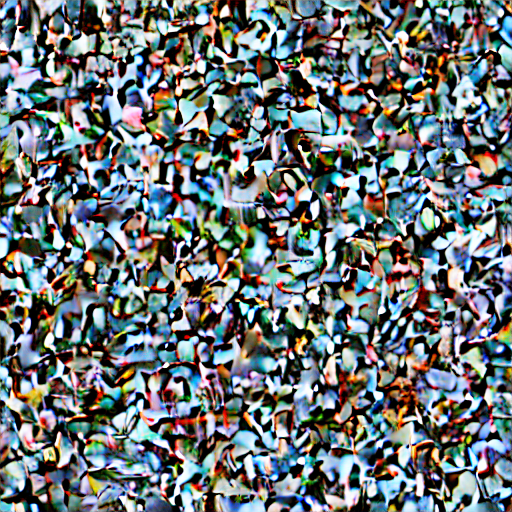

In [31]:
from diffusers.pipelines.pipeline_utils import numpy_to_pil
from diffusers import DDPMScheduler

from model import LLourney

from PIL import Image

# model = LLourney()

def encode_prompt(prompt):
    tokenizer_output = tokenizer(prompt, padding='max_length', truncation=True, max_length=CONTEXT_SIZE)
    input_ids = torch.LongTensor(tokenizer_output["input_ids"]).to(DEVICE)
    attention_mask = torch.Tensor(tokenizer_output["attention_mask"]).to(DEVICE)
    return input_ids, attention_mask

def generate(prompt: str) -> Image:
    prompt = [prompt]
    Z = torch.randn(len(prompt), 4, LATENT_DIM, LATENT_DIM, device=DEVICE)
    scheduler.set_timesteps(NUM_INFERENCE_STEPS)
    timesteps = scheduler.timesteps

    input_ids, attention_mask = encode_prompt(prompt)
    latent_images = Z
    print(f"Latent noise shape: {latent_images.shape}")

    for i, t in enumerate(timesteps):
        batched_t = torch.cat([torch.tensor([t])] * len(prompt), dim=0)
        print(f"Batched t shape: {batched_t.shape}")
        print(f"Input ids 666: {input_ids.shape}")
        print(f"Attention mask 666: {attention_mask.shape}")

        model_output = model(latent_images, input_ids, batched_t, text_pad_mask=attention_mask)
        latent_images = scheduler.step(model_output, t, latent_images).prev_sample

    print(latent_images.shape)
    
    decoded_images = model.decode_image_latents(latent_images)
    image = [numpy_to_pil(img) for img in decoded_images]

    return image[0][0]

# Generate some images
image = generate("Big dog with cricket bat")
display(image)

# print(latent_images.shape)
# decoded_images = model.decode_image_latents(latent_images)
# image = [numpy_to_pil(img) for img in decoded_images]

# # Generate some images
# prompt = ["pokeymans", "big dog with cricket bat", "florgs is GAYYYYYY"]
# Z = torch.randn(len(prompt), 4, LATENT_DIM, LATENT_DIM, device=DEVICE)
# scheduler = DDPMScheduler(num_train_timesteps=NUM_TRAIN_TIMESTEPS)
# scheduler.set_timesteps(NUM_INFERENCE_STEPS)
# timesteps = scheduler.timesteps

# def encode_prompt(prompt):
#     tokenizer_output = tokenizer(prompt, padding='max_length', truncation=True, max_length=CONTEXT_SIZE)
#     input_ids = torch.LongTensor(tokenizer_output["input_ids"]).to(DEVICE)
#     attention_mask = torch.Tensor(tokenizer_output["attention_mask"]).to(DEVICE)
#     return input_ids, attention_mask

# input_ids, attention_mask = encode_prompt(prompt)
# latent_images = Z
# print(f"Latent noise shape: {latent_images.shape}")
# for i, t in enumerate(timesteps):
#     batched_t = torch.cat([torch.tensor([t])] * len(prompt), dim=0)
#     print(f"Batched t shape: {batched_t.shape}")
#     print(f"Input ids 666: {input_ids.shape}")
#     print(f"Attention mask 666: {attention_mask.shape}")
#     model_output = model(latent_images, input_ids, batched_t, text_pad_mask=attention_mask)

#     latent_images = scheduler.step(model_output, t, latent_images).prev_sample

# print(latent_images.shape)
# decoded_images = model.decode_image_latents(latent_images)
# image = [numpy_to_pil(img) for img in decoded_images]

# display(image[0])


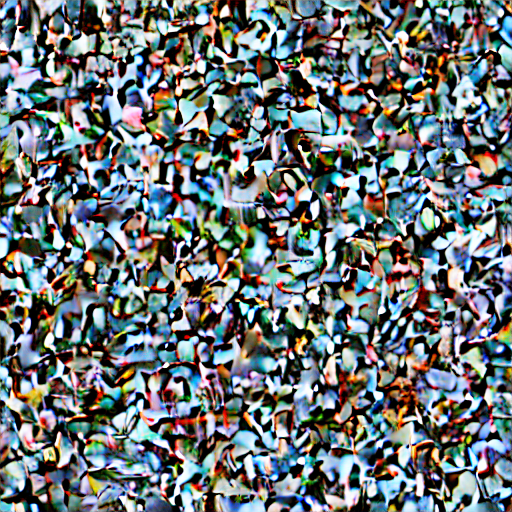

In [32]:
display(image)

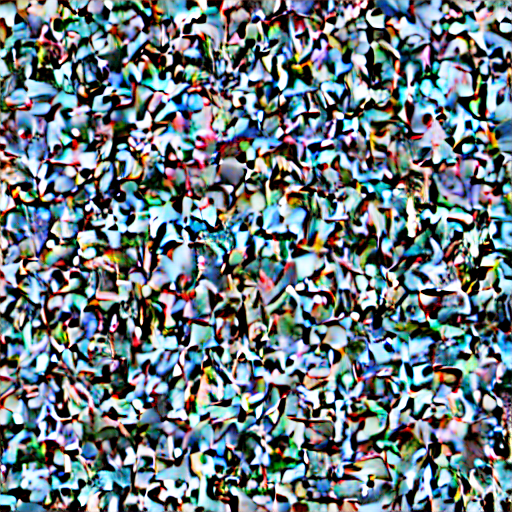

In [21]:
display(image[0][0])

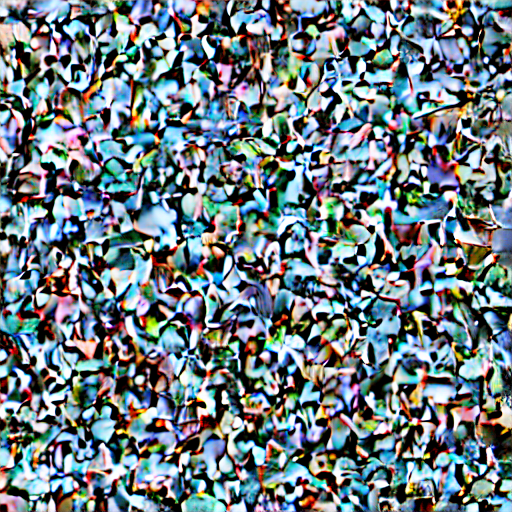

In [22]:
display(image[1][0])

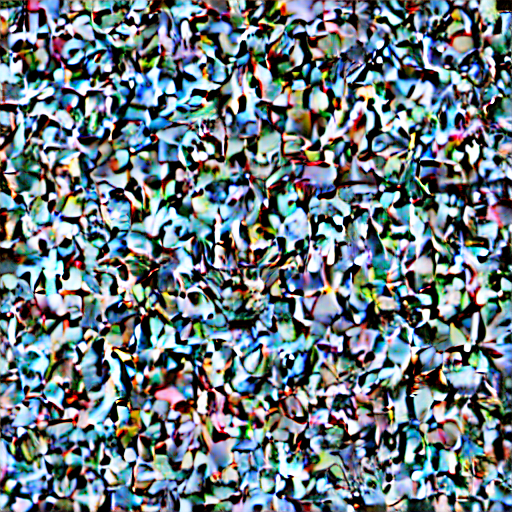

In [23]:
display(image[2][0])

In [ ]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler()

scheduler.set_timesteps(100)

timesteps = scheduler.timesteps

print(timesteps)
print(timesteps[0])

In [31]:
model.llama.config.n_positions

1024

In [32]:
model.llama.config.n_embd

768